In [8]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import arviz as az
np.random.seed(42)

# Visualization 

Data visualization is a very broad area with graphical representations targeting very particular audiences ranging from a scientific paper in some not-over-hyped subject to newspapers with million readers. We will focus on scientific visualizations and in particular visualizations useful in a Bayesian setting.

As humans are generally good at visualizing data, data visualization is both a powerful tool for analyzing data and models and is also a powerful tool to convey information to our target audience. Using words, tables or just numbers is generally less effective to communicate information compared with visualizations. At the same time our visual system can be fooled, as you may have experienced by being tricked by visual illusions.  The reason is that our visual system is tuned to process information in useful ways and this generally means not just *seeing* the information, but *interpreting* it as well. Put less formally, our brains _guess stuff_ and don't just _reproduce the outside world_. Effective data visualization requires that we recognize the abilities and limitations of our own visual systems.

## Plot elements

To convey visual information we generally use shapes, including lines, circles, squares etc. These elements have properties associated to them like, position, shape and color.

ArviZ use both matplotlib and bokeh as plotting backends. While for basic use of ArviZ is not necessary to know about these libraries, being familiar with them is useful in order to better understand some of the arguments in ArviZ's plots and/or to tweak the defaults plots generated with ArviZ. If you need learn more about these libraries we recomend the oficial tutorials for [matplotlib](https://matplotlib.org/stable/tutorials/introductory/usage.html) and [bokeh](https://notebooks.gesis.org/binder/jupyter/user/bokeh-bokeh-notebooks-car10wox/notebooks/tutorial/00%20-%20Introduction%20and%20Setup.ipynb).

## Colors

Matplotlib allows user to easily switch between plotting styles by defining  style sheets. ArviZ is delivered with a few additional styles that can be applied globally by writing `az.style.use(nameofstyle)` or inside a `with` statement.

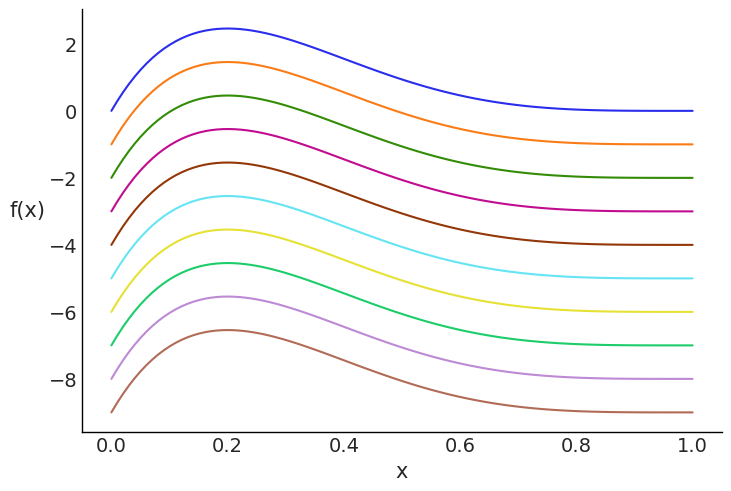

In [9]:
az.style.use('arviz-white')
x = np.linspace(0, 1, 100)
dist = stats.beta(2, 5).pdf(x)

fig = plt.figure()
for i in range(10):
    plt.plot(x, dist - i, f'C{i}', label=f'C{i}')
plt.xlabel('x')
plt.ylabel('f(x)', rotation=0, labelpad=15);

`az.style` is just an alias of `matplotlib.pyplot.style`, so everything you can do with one of them you can do with the other. 

The styles `arviz-colors`, `arviz-white`, `arviz-darkgrid` and `arviz-whitegrid` use the same color-blind friendly palette. This palette was designed using https://colorcyclepicker.mpetroff.net/. If you need to do plots in grey-scale we recommend to restrict yourself to the first 3 colors of the arviz default palette ("C0", "C1" and "C2"), otherwise you may need to use different [line styles](https://matplotlib.org/api/_as_gen/matplotlib.lines.Line2D.html#matplotlib.lines.Line2D.set_linestyle) or [different markers](https://matplotlib.org/api/markers_api.html#module-matplotlib.markers). Another useful palette when the number of colors is restricted is the `grayscale` wich assings greys to the first four colors ("C0", "C1", "C2" and "C3") and the *ArviZ's blue* to "C5". Check [the style gallery](https://arviz-devs.github.io/arviz/examples/styles.html) to see all the available ArviZ's styles.

## Continuous and discrete distributions

A discrete distribution represents variables which can only take a countable number of values. Some examples of discrete random variables are the number of coins in your pocket, spots on a giraffe, red cars in a city, people with flu etc. As we generally use integers to represent discrete variables, when ArviZ is asked to plot integer data it will use [histograms](https://en.wikipedia.org/wiki/Histogram) to represent them. ArviZ always tries to associate the discrete data to individuals bins. For example in the following plot each _bar_ is associated with an integer in the interval [0, 9].

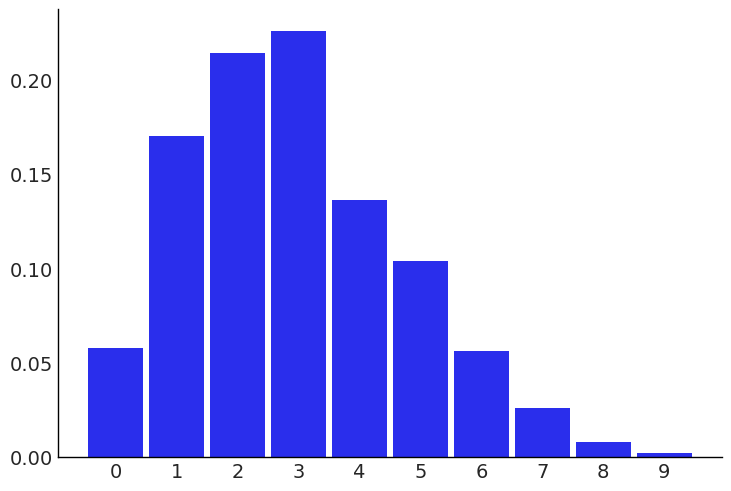

In [10]:
d_values = stats.poisson(3).rvs(500)
az.plot_dist(d_values);

When the discrete values takes higher values, like in the following example, bins are still associated with integers but not every integer will be associated with a single different bins. Instead many integers will be binned together.

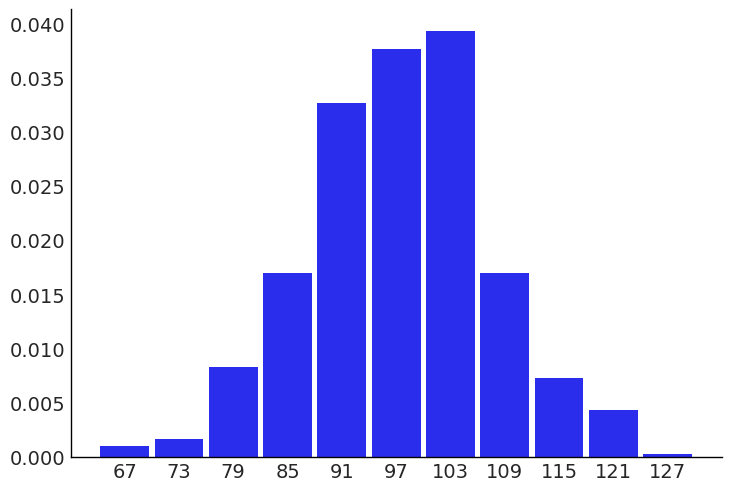

In [11]:
d_values = stats.poisson(100).rvs(500)
az.plot_dist(d_values);

If you don't like the default binning criteria of ArviZ, you can change it by passing the `bins` argument using the `hist_kwargs`.

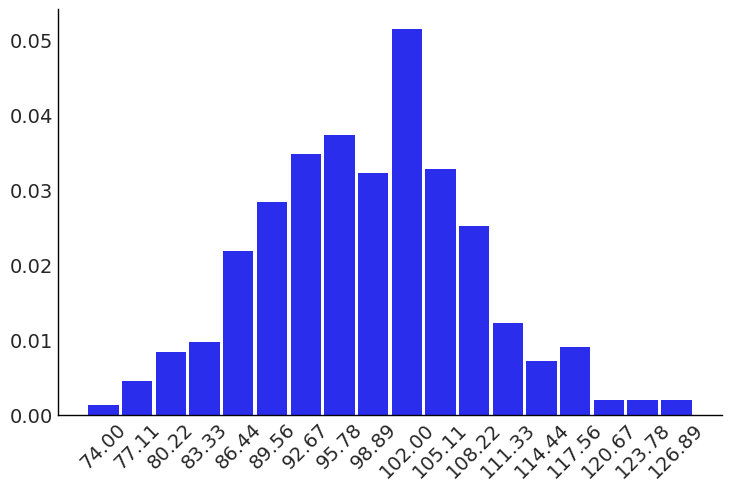

In [12]:
d_values = stats.poisson(100).rvs(500)
ax = az.plot_dist(d_values, hist_kwargs={"bins":"auto"})
plt.setp(ax.get_xticklabels(), rotation=45);

A continuous distribution represents variables taking an uncountable number of values. Some examples of continuous random variables are the temperature during summer, the blood pressure of a patience, the time needed to finish a task, etc. By default ArviZ uses kernel density estimation (KDE) to represent continuous distributions.

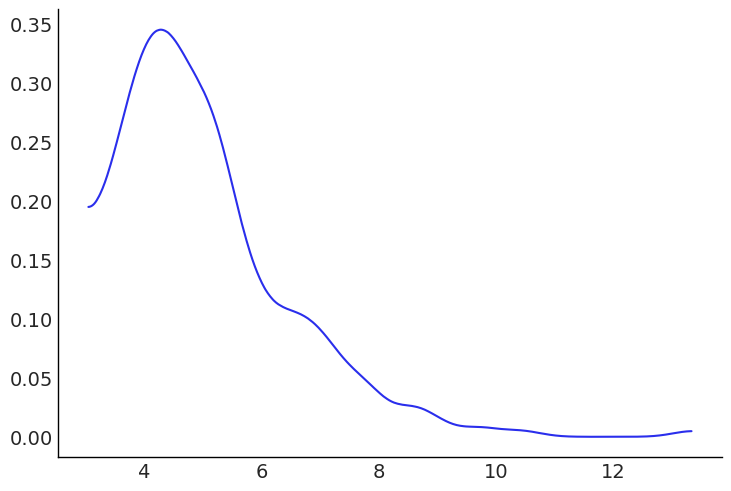

In [13]:
c_values = stats.gamma(2, 3).rvs(500)
az.plot_dist(c_values);

Kernel density estimation (KDE) is a non-parametric way to estimate the probability density function of a random variable.

Conceptually you place a _kernel function_ like a gaussian _on top_ of a data-point, then you sum all the gaussians, generally evaluated over a grid and not over the data points. Results are normalized so the total area under the curve is one. 

The following block of code shows a very simple example of a KDE.

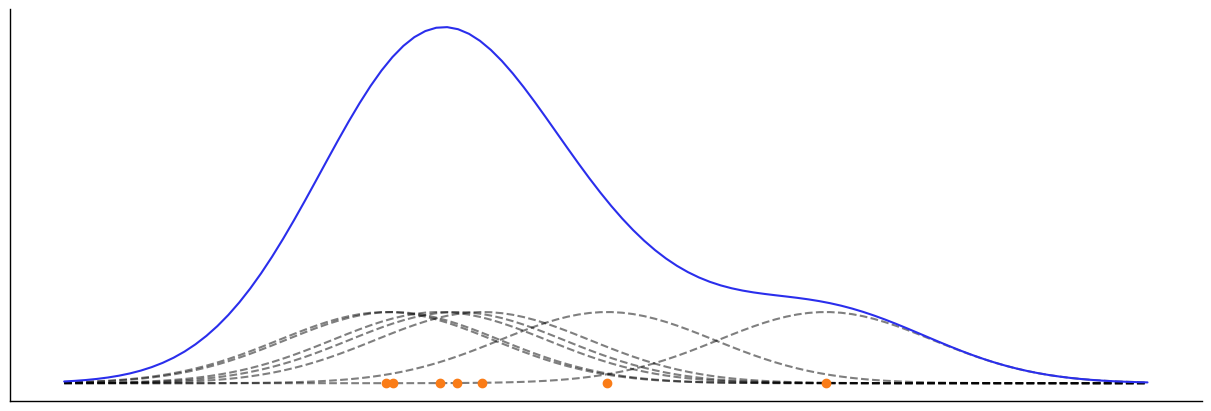

In [14]:
_, ax = plt.subplots(figsize=(12, 4))
bw = 0.4
np.random.seed(19)
datapoints = 7
y = np.random.normal(7, size=datapoints)
x = np.linspace(y.min() - bw * 3, y.max() + bw * 3, 100)
kernels = np.transpose([stats.norm.pdf(x, i, bw) for i in y])
kernels *= 1/datapoints  # normalize the results
ax.plot(x, kernels, 'k--', alpha=0.5)
ax.plot(y, np.zeros(len(y)), 'C1o')
ax.plot(x, kernels.sum(1))

ax.set_xticks([])
ax.set_yticks([]);

Compared to other KDEs in the Python ecosystem, the KDE implemented in ArviZ automatically handles the boundaries of a distribution. Basically, ArviZ will assign a density of zero to any point outside the range of the data. Another nice feature of ArviZ's KDE is the method it uses to estimate the _bandwith_.  The bandwidth of a kernel density estimator is a parameter that controls its degree of smoothness.  ArviZ's method works  well for a wide range of distributions including multimodal ones. The following plot compares the KDEs for ArviZ (on the left) and SciPy (on the right). The blue line is the theoretical distribution, the light blue bars give a histogram computed from samples drawn from the distribution, and the orange lines are the kernel density estimations.

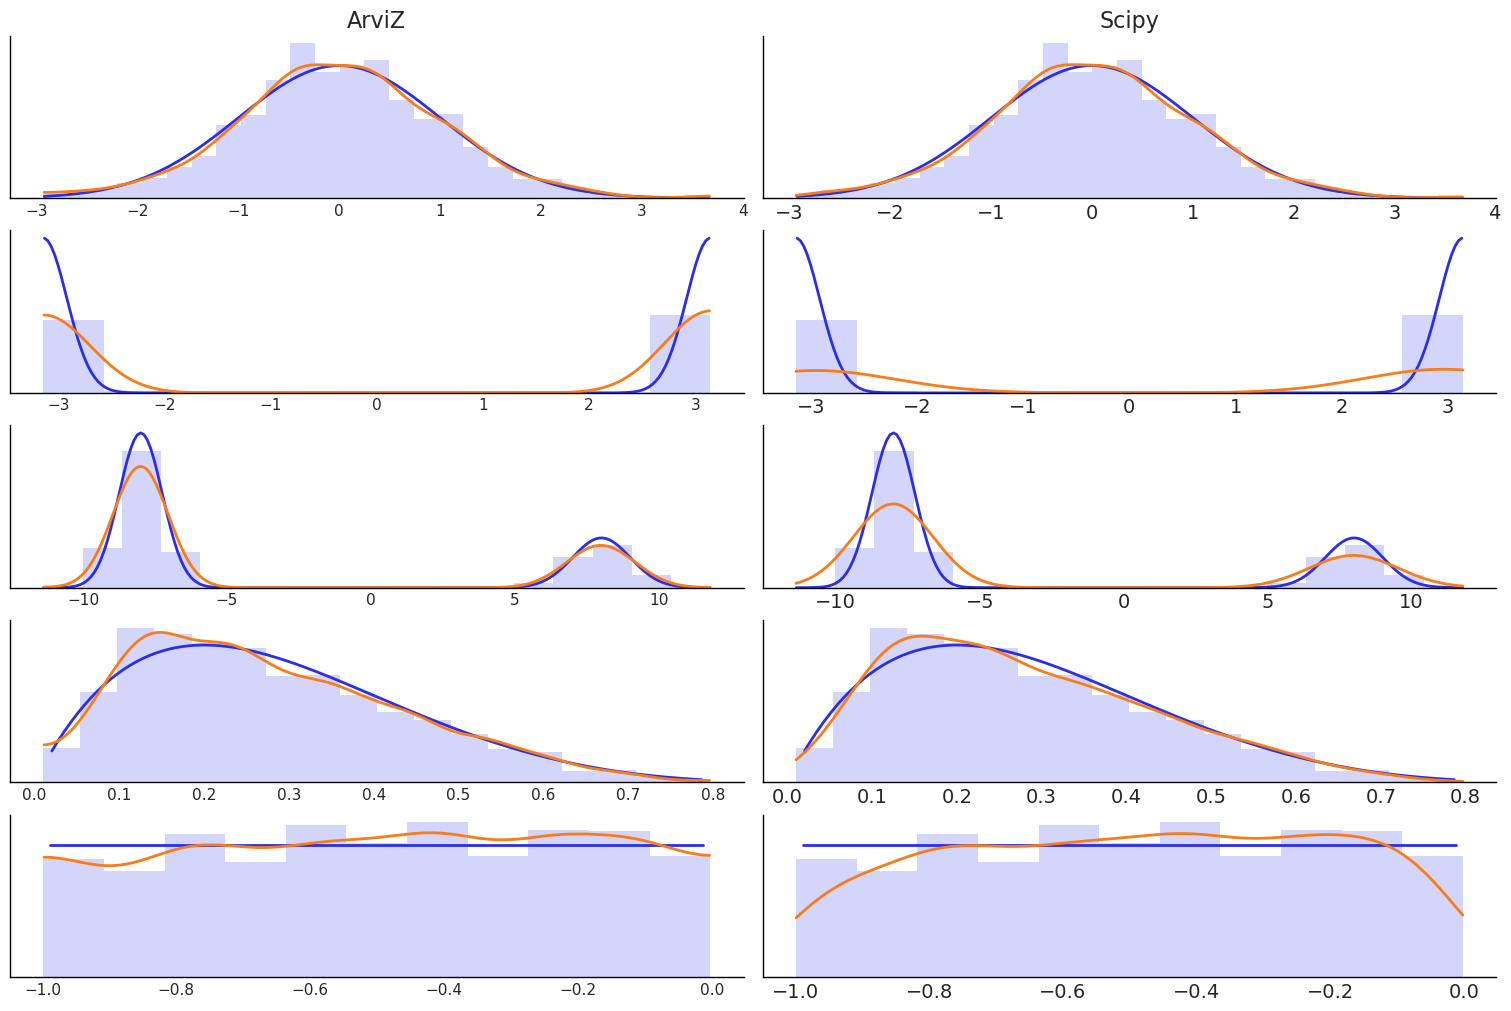

In [16]:
def scipykdeplot(data, ax, **kwargs):
    x = np.linspace(data.min(), data.max(), len(data))
    kde = stats.gaussian_kde(data)
    density = kde.evaluate(x)
    ax.plot(x, density, **kwargs)

size = 1000
_, ax = plt.subplots(5, 2, figsize=(15, 10), constrained_layout=True)

a_dist = stats.vonmises(loc=np.pi, kappa=20)
b_dist = stats.beta(a=2, b=5)
c_dist = [stats.norm(-8, 0.75), stats.norm(8, 1)]
d_dist = stats.norm(0, 1)
e_dist = stats.uniform(-1, 1)
a = a_dist.rvs(size)
a = np.arctan2(np.sin(a), np.cos(a))
b = b_dist.rvs(size)
c = np.concatenate((c_dist[0].rvs(7000), c_dist[1].rvs(3000)))
d = d_dist.rvs(size)
e = e_dist.rvs(size)


ax[0, 0].set_title('ArviZ')
ax[0, 1].set_title('Scipy')

for idx, (i, dist) in enumerate(zip([d, a, c, b, e], [d_dist, a_dist, c_dist, b_dist,  e_dist] )):
    x = np.linspace(i.min()+0.01, i.max()-0.01, 200)
    if idx == 2:
        x_dist = np.concatenate((dist[0].pdf(x[:100]) * 0.7, dist[1].pdf(x[100:]) * 0.3))
    else:
        x_dist = dist.pdf(x)

    ax[idx, 0].plot(x, x_dist, 'C0', lw=2) 
    az.plot_kde(i, ax=ax[idx, 0], textsize=11, plot_kwargs={'color':'C1', 'linewidth':2})
    ax[idx, 0].set_yticks([])
    ax[idx, 0].hist(i, bins='auto', alpha=0.2, density=True)

    ax[idx, 1].plot(x, x_dist, 'C0', lw=2) 
    scipykdeplot(i, ax=ax[idx, 1], color='C1', lw=2)
    ax[idx, 1].set_yticks([])
    ax[idx, 1].hist(i, bins='auto', alpha=0.2, density=True)